# SUSTAV ZA DETEKCIJU KARAKTERISTIČNIH TOČAKA LICA
Toni Polanec 2023.


In [63]:

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import math
import random
from sklearn.impute import SimpleImputer
from tqdm.keras import TqdmCallback
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam


## Analiza podataka

In [64]:
# učitanje slika
face_images = np.load('face_images.npz')
faces=face_images.get(face_images.files[0]) 

# oblikovanje polja
faces=np.moveaxis(faces,-1,0)
faces=faces.reshape(faces.shape[0],faces.shape[1],faces.shape[1],1)

In [65]:
faces.shape

(7049, 96, 96, 1)

Ukupno imamo **7049** različitih slika.  
Svaka slika je veličine **96x96** piksela. 


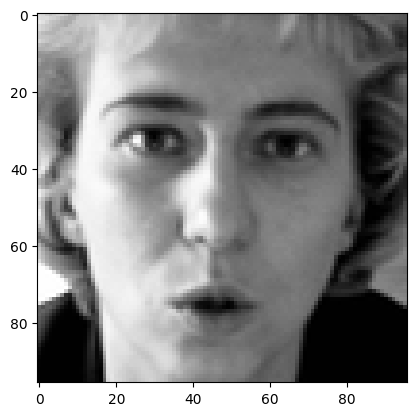

In [66]:
plt.imshow(faces[1], cmap='gray')

^ primjer slike

In [67]:
# čitanje datoteke s karakterističnim točkama lica
landmarks = pd.read_csv('facial_keypoints.csv')
landmarks.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


Korišteni dataset ima sveukupno 15 karakterističnih točaka lica.  
U ovom radu koristiti 4 točke, i to:
- centar lijevog oka
- centar desnog oka
- vrh nosa
- centar donje usne

In [68]:
# brisanje podataka o obrvama i ustima (osim bottom_lip_center)
landmarks = landmarks.drop(['left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y'], axis=1)

In [69]:
landmarks.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.244810
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
nose_tip_x,44.420571,48.206298,47.557263,51.885078,43.299534
nose_tip_y,57.066803,55.660936,53.538947,54.166539,64.889521
mouth_center_bottom_lip_x,43.130707,45.467915,47.274947,51.561183,44.227141
mouth_center_bottom_lip_y,84.485774,85.480170,78.659368,78.268383,86.871166


In [70]:
landmarks.shape

(7049, 8)

Za svaku sliku imamo 8 parametara koji predstavljaju koordinate 4 različitih točaka na licu (x,y).  
<br>
Zbog nepravilnosti dataseta moramo provjeriti koliko ima nepostojećih vrijednosti.

In [71]:
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()

left_eye_center_x            10
left_eye_center_y            10
right_eye_center_x           13
right_eye_center_y           13
nose_tip_x                    0
nose_tip_y                    0
mouth_center_bottom_lip_x    33
mouth_center_bottom_lip_y    33
dtype: int64

Vidimo da ih ima dosta pa ćemo to sanirati u sljedećim koracima.

#### Prikaz tablice korelacije između karakterističnih točaka lica:

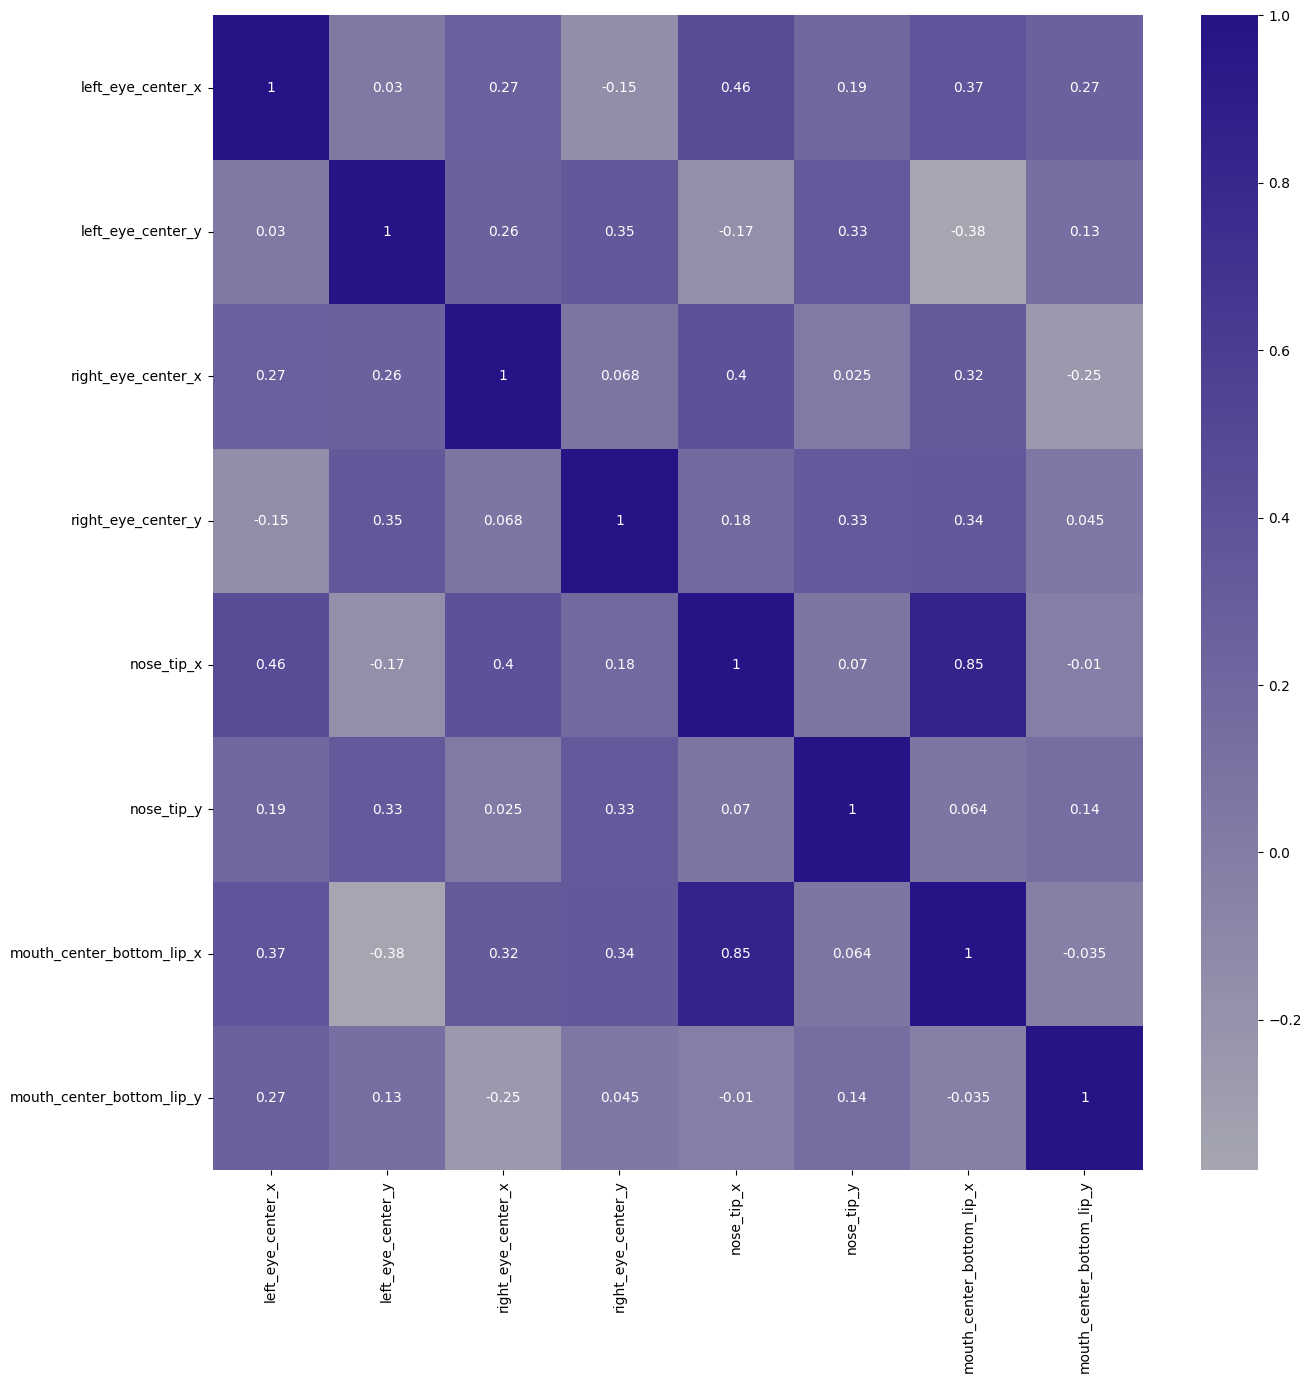

In [72]:
landmarks_correlation = landmarks.corr()

plt.figure(figsize=(15,15))
sns.heatmap(landmarks_correlation, cmap=sns.color_palette("blend:#A5A6B1,#271286", as_cmap=True), annot=True)
plt.show()


Po grafu iznad vidimo da imamo korelacije između nekih točaka u datasetu. Npr. *nose_tip_x* i mouth_center_bottom_lip_x* imaju korelaciju od 0.85.  
To ćemo iskoristiti da popunimo null vrijednosti u datasetu.  



## Predprocesiranje podataka

Po analizi podataka dobili smo informaciju da za karakterističnu točku *eye_center* fali samo 13 vrijednosti. Pa umijesto da izmišljamo vrijednosti za te točke, odlučio sam ih izbaciti iz dataseta.



In [73]:
empty_rows = landmarks[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y']].isnull().any(axis=1)
null_indexes = landmarks[empty_rows].index

# brisanje slika koje imaju te određene točke s null vrijednostima
faces = np.delete(faces, null_indexes, axis=0)
landmarks = landmarks.dropna(subset=['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y'], how='any')


print("landmarks.shape ->", landmarks.shape)
print("faces.shape ->", faces.shape)
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()




landmarks.shape -> (7033, 8)
faces.shape -> (7033, 96, 96, 1)


left_eye_center_x             0
left_eye_center_y             0
right_eye_center_x            0
right_eye_center_y            0
nose_tip_x                    0
nose_tip_y                    0
mouth_center_bottom_lip_x    33
mouth_center_bottom_lip_y    33
dtype: int64

Isto tako za *mouth_center_bottom_lip* fali 33 vrijednosti, pa ćemo i njih izbaciti iz dataseta.


In [74]:
empty_rows = landmarks[['mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']].isnull().any(axis=1)
null_indexes = landmarks[empty_rows].index

# brisanje slika koje imaju te određene točke s null vrijednostima
faces = np.delete(faces, null_indexes, axis=0)
landmarks = landmarks.dropna(subset=['mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'], how='any')

print("landmarks.shape ->", landmarks.shape)
print("faces.shape ->", faces.shape)
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()

landmarks.shape -> (7000, 8)
faces.shape -> (7000, 96, 96, 1)


left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
nose_tip_x                   0
nose_tip_y                   0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
dtype: int64

### Popunjavanje null vrijednosti

In [75]:
# # podjela na skup s null vrijednostima i skup bez null vrijednosti
# landmarks_null = landmarks[landmarks.isnull().any(axis=1)]
# landmarks_not_null = landmarks.dropna()

# print(f"landmarks_null:{landmarks_null.shape}   landmarks_not_null:{landmarks_not_null.shape}")

Sad vidimo da imamo točku centra lijevog i desnog oka, pomoću tih koordinata izračunati ćemo koordinate točaka oko oka koje nedostaju.  
OČI:   *left_eye_inner_corner left_eye_outer_corner, right_eye_inner_corner right_eye_outer_corner*  

Isto tako za usta, imamo točku donjeg centra usne.  
USTA:  *mouth_center_top_lip*    



In [76]:
# not_null_size = landmarks_not_null.shape[0]
# print(f"not_null_size: {not_null_size}")

# # EYES

# left_eye_inner_corner_x_avg_diff = (landmarks_not_null['left_eye_inner_corner_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
# left_eye_inner_corner_y_avg_diff = (landmarks_not_null['left_eye_inner_corner_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size

# left_eye_outer_corner_x_avg_diff = (landmarks_not_null['left_eye_outer_corner_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
# left_eye_outer_corner_y_avg_diff = (landmarks_not_null['left_eye_outer_corner_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size

# right_eye_inner_corner_x_avg_diff = (landmarks_not_null['right_eye_inner_corner_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
# right_eye_inner_corner_y_avg_diff = (landmarks_not_null['right_eye_inner_corner_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size

# right_eye_outer_corner_x_avg_diff = (landmarks_not_null['right_eye_outer_corner_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
# right_eye_outer_corner_y_avg_diff = (landmarks_not_null['right_eye_outer_corner_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size


# # MOUTH

# mouth_center_top_lip_x_avg_diff = (landmarks_not_null['mouth_center_top_lip_x'].values - landmarks_not_null['mouth_center_bottom_lip_x'].values).sum() / not_null_size
# mouth_center_top_lip_y_avg_diff = (landmarks_not_null['mouth_center_top_lip_y'].values - landmarks_not_null['mouth_center_bottom_lip_y'].values).sum() / not_null_size


# print("\nRavnamo se po 'Left eye center':\n" +
#     f"left_eye_inner_corner_x_avg_diff:\t{left_eye_inner_corner_x_avg_diff}\n" +
#     f"left_eye_inner_corner_y_avg_diff:\t{left_eye_inner_corner_y_avg_diff}\n" +
#     f"left_eye_outer_corner_x_avg_diff:\t{left_eye_outer_corner_x_avg_diff}\n" +
#     f"left_eye_outer_corner_y_avg_diff:\t{left_eye_outer_corner_y_avg_diff}\n" +
#     "\nRavnamo se po 'Right eye center':\n" +
#     f"right_eye_inner_corner_x_avg_diff:\t{right_eye_inner_corner_x_avg_diff}\n" +
#     f"right_eye_inner_corner_y_avg_diff:\t{right_eye_inner_corner_y_avg_diff}\n" +
#     f"right_eye_outer_corner_x_avg_diff:\t{right_eye_outer_corner_x_avg_diff}\n" +
#     f"right_eye_outer_corner_y_avg_diff:\t{right_eye_outer_corner_y_avg_diff}\n" +
    
#     "\nRavnamo se po 'Mouth center bottom lip':\n" +
#     f"mouth_center_top_lip_x_avg_diff:\t{mouth_center_top_lip_x_avg_diff}\n" +
#     f"mouth_center_top_lip_y_avg_diff:\t{mouth_center_top_lip_y_avg_diff}\n"
#     )


Sad imamo prosječne udaljenosti od poznatih točaka.  
Možemo popuniti sve null vrijednosti tako da dodamo ili oduzmemo prosječnu udaljenost od poznate točke.

In [77]:
# # EYES
# landmarks['left_eye_inner_corner_x'] = landmarks['left_eye_inner_corner_x'].fillna(landmarks['left_eye_center_x'] + left_eye_inner_corner_x_avg_diff)
# landmarks['left_eye_inner_corner_y'] = landmarks['left_eye_inner_corner_y'].fillna(landmarks['left_eye_center_y'] + left_eye_inner_corner_y_avg_diff)

# landmarks['left_eye_outer_corner_x'] = landmarks['left_eye_outer_corner_x'].fillna(landmarks['left_eye_center_x'] + left_eye_outer_corner_x_avg_diff)
# landmarks['left_eye_outer_corner_y'] = landmarks['left_eye_outer_corner_y'].fillna(landmarks['left_eye_center_y'] + left_eye_outer_corner_y_avg_diff)

# landmarks['right_eye_inner_corner_x'] = landmarks['right_eye_inner_corner_x'].fillna(landmarks['right_eye_center_x'] + right_eye_inner_corner_x_avg_diff)
# landmarks['right_eye_inner_corner_y'] = landmarks['right_eye_inner_corner_y'].fillna(landmarks['right_eye_center_y'] + right_eye_inner_corner_y_avg_diff)

# landmarks['right_eye_outer_corner_x'] = landmarks['right_eye_outer_corner_x'].fillna(landmarks['right_eye_center_x'] + right_eye_outer_corner_x_avg_diff)
# landmarks['right_eye_outer_corner_y'] = landmarks['right_eye_outer_corner_y'].fillna(landmarks['right_eye_center_y'] + right_eye_outer_corner_y_avg_diff)

# # MOUTH
# landmarks['mouth_center_top_lip_x'] = landmarks['mouth_center_top_lip_x'].fillna(landmarks['mouth_center_bottom_lip_x'] + mouth_center_top_lip_x_avg_diff)
# landmarks['mouth_center_top_lip_y'] = landmarks['mouth_center_top_lip_y'].fillna(landmarks['mouth_center_bottom_lip_y'] + mouth_center_top_lip_y_avg_diff)

# # Provjera ako sad još uvijek ima null vrijednosti
# landmarks.isnull().sum()

### Vizualizacija podataka

In [78]:
# https://www.kaggle.com/code/satyaprakash13820/facial-landmark?scriptVersionId=76260280&cellId=13


print(f"faces.shape -> {faces.shape}")
landmark_len = len(landmarks)
print(f"key_feature_num -> {landmark_len}\n")

normalized_faces = faces
normalized_faces = normalized_faces/255 # Normalizacija

landmarks.reset_index(drop=True, inplace=True)

print(f"normalized_faces.shape -> {normalized_faces.shape}")
print(normalized_faces)



faces.shape -> (7000, 96, 96, 1)
key_feature_num -> 7000

normalized_faces.shape -> (7000, 96, 96, 1)
[[[[0.93333333]
   [0.9254902 ]
   [0.92941176]
   ...
   [0.98039216]
   [0.98039216]
   [0.98039216]]

  [[0.92156863]
   [0.93333333]
   [0.9254902 ]
   ...
   [0.97647059]
   [0.98039216]
   [0.98431373]]

  [[0.92941176]
   [0.9254902 ]
   [0.92941176]
   ...
   [0.98431373]
   [0.98431373]
   [0.98039216]]

  ...

  [[0.72941176]
   [0.71764706]
   [0.70980392]
   ...
   [0.20392157]
   [0.22352941]
   [0.23529412]]

  [[0.74117647]
   [0.7372549 ]
   [0.81176471]
   ...
   [0.23921569]
   [0.27058824]
   [0.30588235]]

  [[0.74901961]
   [0.72156863]
   [0.72156863]
   ...
   [0.2745098 ]
   [0.29411765]
   [0.35294118]]]


 [[[0.85882353]
   [0.84313725]
   [0.8       ]
   ...
   [0.36078431]
   [0.34509804]
   [0.32941176]]

  [[0.87058824]
   [0.85882353]
   [0.8627451 ]
   ...
   [0.36078431]
   [0.34509804]
   [0.3372549 ]]

  [[0.90588235]
   [0.87843137]
   [0.83137255]
 

In [79]:
def plot_image(image_array, landmarks, index):
    plt.imshow(image_array[index], cmap='gray')
    plt.scatter(landmarks.iloc[index,0::2], landmarks.iloc[index,1::2], c="#0f0", marker='P')
    plt.show()

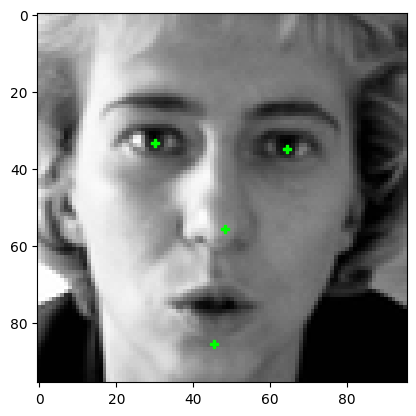

In [80]:
plot_image(normalized_faces, landmarks, 1)

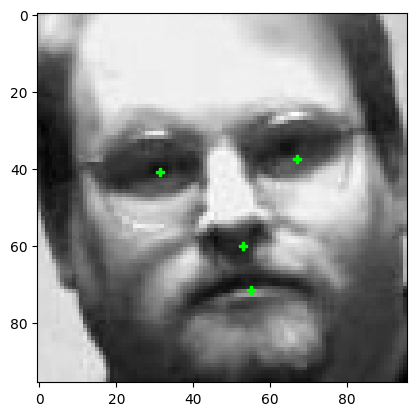

In [81]:
plot_image(normalized_faces, landmarks, 5000)

Neke točke nisu najpreciznije označene, ali to je nedostatak izračunavanja nedostajućih vrijednosti u datasetu i sa tim ćemo morati živjeti.

In [82]:
def plot_mult_images(image_array, landmarks, rows = 3, cols = 3):
    default_pics = [random.randint(0,2000) for i in range(rows*cols)]
    pic_size = 96
    index = 0

    fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
    for row in range(rows):
        for col in range(cols):
            ax[row,col].imshow(image_array[default_pics[index]], cmap='gray')
            ax[row,col].scatter(landmarks.iloc[index,0::2], landmarks.iloc[index,1::2], c="#0f0", marker='+')
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(default_pics[index]),fontsize=10)
            index += 1

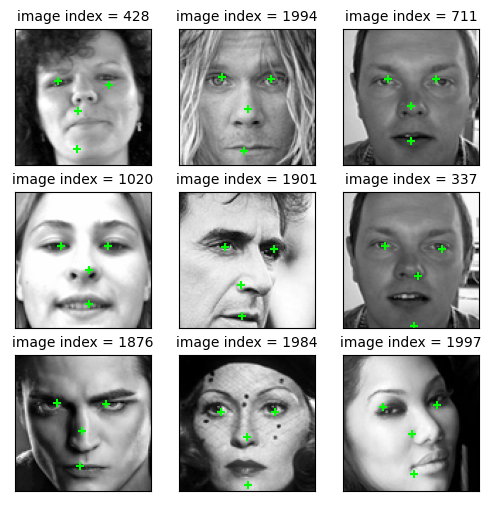

In [83]:
plot_mult_images(normalized_faces, landmarks)

## Model

Priprema podataka za treniranje modela.

In [100]:
train_x,test_x,train_y,test_y=train_test_split(normalized_faces, landmarks, test_size=0.2, random_state=42)

print(f"train_x.shape -> {train_x.shape}")
print(f"train_y.shape -> {train_y.shape}")
print(f"test_x.shape  -> {test_x.shape}")
print(f"test_y.shape  -> {test_y.shape}")



train_x.shape -> (1400, 96, 96, 1)
train_y.shape -> (1400, 8)
test_x.shape  -> (5600, 96, 96, 1)
test_y.shape  -> (5600, 8)


In [85]:
# Use Sequential Layer and Batch Normalisation layer
img_size=96
model=Sequential()

model.add(Input(shape=(img_size, img_size, 1)))

model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Now adding Flatten Layer and Dense layer in the Model

model.add(Flatten())
model.add(Dense(256,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0))
model.add(Dense(8,kernel_initializer=glorot_uniform()))

In [86]:
model.summary()                      

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 96, 96, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        320       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 32)      

In [87]:
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mean_squared_error'])

In [88]:
batch_size = 16
epochs = 200

history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y), verbose=1)

model.save('model_temp.h5')

Epoch 1/200
350/350 [==============================] - 61s 172ms/step - loss: 97.9038 - mean_squared_error: 97.9038 - val_loss: 136.4440 - val_mean_squared_error: 136.4440
Epoch 2/200
350/350 [==============================] - 59s 168ms/step - loss: 45.7944 - mean_squared_error: 45.7944 - val_loss: 534.6957 - val_mean_squared_error: 534.6957
Epoch 3/200
350/350 [==============================] - 59s 168ms/step - loss: 35.0207 - mean_squared_error: 35.0207 - val_loss: 593.4463 - val_mean_squared_error: 593.4463
Epoch 4/200
350/350 [==============================] - 59s 168ms/step - loss: 31.7750 - mean_squared_error: 31.7750 - val_loss: 582.7261 - val_mean_squared_error: 582.7261
Epoch 5/200
350/350 [==============================] - 61s 174ms/step - loss: 27.4756 - mean_squared_error: 27.4756 - val_loss: 645.8734 - val_mean_squared_error: 645.8734
Epoch 6/200
350/350 [==============================] - 59s 169ms/step - loss: 27.1812 - mean_squared_error: 27.1812 - val_loss: 633.1721 - v

In [ ]:
# model.save('model.h5')

---

In [27]:
# model = load_model('model_300epochs.h5')

---

Možemo prikazati graf smanjenja greške predikcije kroz epohe.  

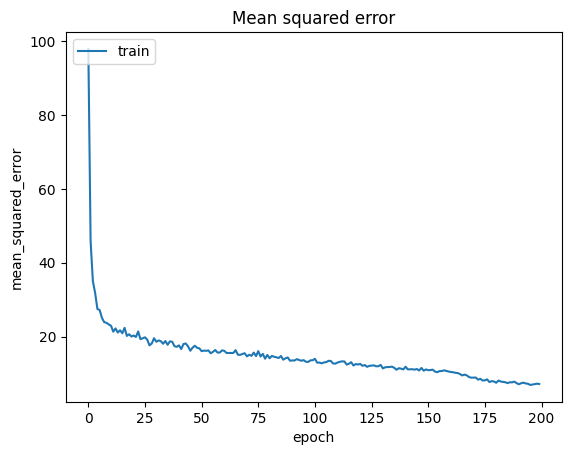

In [89]:

plt.plot(history.history['mean_squared_error'])
plt.title('Mean squared error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
y_pred = model.predict(test_x)

175/175 [==============================] - 9s 54ms/step


In [28]:
def plot_predicted_image(images, truth, prediction, index):
    print(index, "->" , prediction[index])
    plt.imshow(images[index], cmap='gray')
    plt.scatter(truth.iloc[index, 0::2], truth.iloc[index, 1::2], c="#0f0", marker='P')
    plt.scatter(prediction[index, 0::2], prediction[index, 1::2], c="#f00", marker='P')
    plt.legend(["Truth","Prediction"])
    plt.show()

Usporedimo predicted sliku s originalnom slikom.


10 -> [45.854774 26.62226  21.095438 25.588001 33.006363 37.257713 32.548584
 57.77953 ]


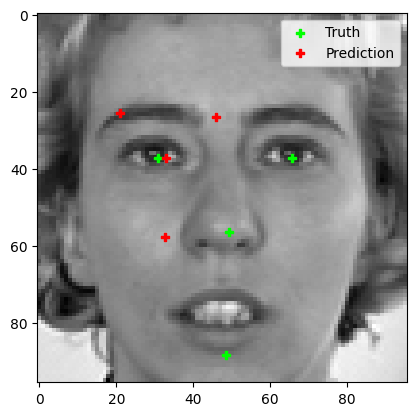

In [102]:
plot_predicted_image(test_x, test_y, y_pred, 10)

In [103]:
def plot_predicted_images(images, truth, prediction, indexes = [10, 11, 30, 41, 51, 60, 75, 89, 91]):
    rows = 3
    cols = 3

    arr_i = 0
    fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
    for row in range(rows):
        for col in range(cols):
            index = indexes[arr_i]
            ax[row,col].imshow(images[index], cmap='gray')
            ax[row,col].scatter(truth.iloc[index, 0::2], truth.iloc[index, 1::2], c="#0f0", marker='+')
            ax[row,col].scatter(prediction[index, 0::2], prediction[index, 1::2], c="#f00", marker='+')
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(index),fontsize=10)
            arr_i += 1

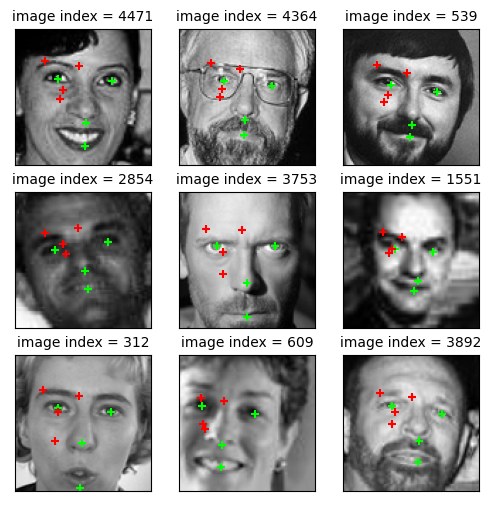

In [104]:
random_indexes = [random.randint(0, len(test_x)) for i in range(9)]
plot_predicted_images(test_x, test_y, y_pred, random_indexes)

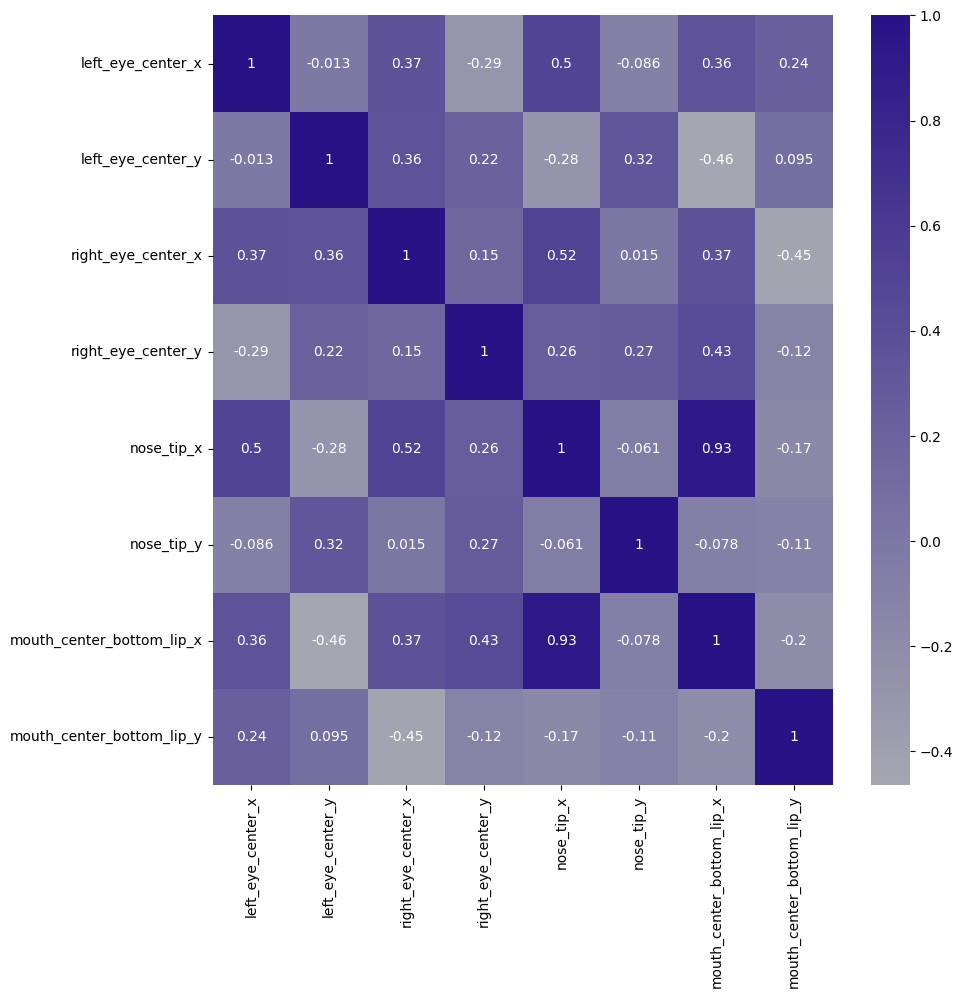

In [105]:
landmarks_trained = pd.DataFrame(y_pred, columns=landmarks.columns)
landmarks_trained.head()
plt.figure(figsize=(10,10))
sns.heatmap(landmarks_trained.corr(), cmap=sns.color_palette("blend:#A5A6B1,#271286", as_cmap=True), annot=True)
plt.show()

In [107]:
landmarks_trained.T

,0,1,2,3,4,5,6,7,8,9,...,5590,5591,5592,5593,5594,5595,5596,5597,5598,5599
left_eye_center_x,44.499977,43.145737,45.095104,46.903168,46.603279,43.503040,47.035625,42.960335,44.870842,45.363750,...,43.722404,46.736214,44.113838,46.265755,45.900455,43.363049,44.387295,31.730154,42.427464,43.250919
left_eye_center_y,24.729425,26.929813,25.687511,24.099529,27.076105,28.550434,28.956633,27.965693,28.435163,30.801001,...,25.355593,30.513601,29.308607,29.599474,25.059702,26.231180,27.492228,49.099602,21.880127,29.565060
right_eye_center_x,19.135368,20.575634,20.322514,19.573427,23.409081,24.361393,23.702322,20.324465,20.383244,22.665401,...,20.711458,22.907784,20.742266,23.269777,22.973543,19.327423,22.043144,24.492701,18.068943,25.610367
right_eye_center_y,23.082767,25.420124,23.285221,23.039352,25.448509,26.433765,26.420555,23.872066,24.348988,19.994221,...,23.389206,25.751320,26.251575,23.513245,29.202297,26.851803,26.961605,47.180748,24.714081,29.529362
nose_tip_x,27.266132,33.027290,30.618544,32.010311,33.730000,33.329353,35.949890,24.957670,29.339260,27.836311,...,30.263155,27.879192,25.326099,26.504135,36.606125,31.197369,32.544868,25.099043,30.069679,35.064949
nose_tip_y,45.729805,41.045330,42.949474,32.957787,43.475346,43.092190,46.099384,39.953838,41.610172,43.527210,...,37.808388,47.757660,46.641441,42.989552,40.223560,38.302750,42.430927,56.034534,36.385300,39.763985
mouth_center_bottom_lip_x,28.127407,31.635277,29.934586,31.890224,33.204090,32.191471,34.097301,25.074928,28.127853,23.475094,...,29.781700,27.699486,26.299862,25.999104,38.459927,31.676552,32.501419,25.460499,31.974014,34.816246
mouth_center_bottom_lip_y,51.067936,46.077297,56.113400,55.563278,49.642677,48.559399,51.970757,57.377201,50.332485,48.381882,...,55.389091,53.664375,55.115990,49.418468,45.962204,57.851200,49.164524,56.545418,54.005466,45.178734


In [109]:
landmarks_trained.describe().T

,count,mean,std,min,25%,50%,75%,max
left_eye_center_x,5600.0,44.396481,2.527767,13.907492,43.294845,44.502035,45.683858,74.660477
left_eye_center_y,5600.0,26.406322,2.560708,-1.239724,24.928009,26.318675,27.709603,60.411278
right_eye_center_x,5600.0,21.154814,2.344637,-5.090470,19.763362,21.011483,22.357237,70.510681
right_eye_center_y,5600.0,25.743568,2.349360,-3.202239,24.366194,25.687117,27.089740,56.778004
nose_tip_x,5600.0,31.809383,3.584842,3.366619,30.159699,31.824101,33.606386,77.410904
nose_tip_y,5600.0,40.962601,4.506494,6.945233,38.487218,41.800215,43.916656,67.631805
mouth_center_bottom_lip_x,5600.0,31.813158,3.741791,5.133712,29.959809,31.838600,33.746884,73.347420
mouth_center_bottom_lip_y,5600.0,51.023666,4.239277,7.159657,48.071768,50.369385,53.672297,68.003510


In [108]:
landmarks.describe().T

,count,mean,std,min,25%,50%,75%,max
left_eye_center_x,7000.0,66.349400,3.377149,22.763345,65.082412,66.490445,68.019111,94.689280
left_eye_center_y,7000.0,37.618104,3.036592,1.616512,35.897951,37.521582,39.240560,80.502649
right_eye_center_x,7000.0,30.303407,2.948946,0.686592,28.788607,30.252292,31.766950,85.039381
right_eye_center_y,7000.0,37.942656,2.884111,4.091264,36.326021,37.807311,39.555408,81.270911
nose_tip_x,7000.0,48.372452,4.171588,12.944699,46.610759,48.424901,50.326257,89.438592
nose_tip_y,7000.0,62.682027,5.621675,17.932414,59.304250,63.452070,66.485677,88.825658
mouth_center_bottom_lip_x,7000.0,48.571676,4.237941,12.536477,46.582199,48.595419,50.676650,89.438592
mouth_center_bottom_lip_y,7000.0,78.975710,5.407683,25.850503,75.555473,78.698200,82.234908,95.808983


In [35]:
for i in landmarks.columns:
    index = 0
    for l in landmarks[i]:
        if l < 0 or l > 96:
            print(i, l)
            print(index)
        index += 1
            


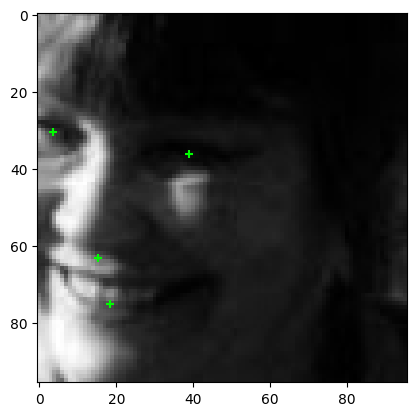

In [36]:
ind = 6268
plt.imshow(normalized_faces[ind], cmap='gray')
plt.scatter(landmarks.iloc[ind,0::2], landmarks.iloc[ind,1::2], c="#0f0", marker='+')
plt.show()

left_eye_center_x            66.033564
right_eye_center_x           30.227008
nose_tip_x                   44.420571
mouth_center_bottom_lip_x    43.130707
Name: 0, dtype: float64


InvalidIndexError: (array([42.934097, 22.721287, 19.494246, 23.96004 , 30.172453, 39.178486,
       31.429613, 50.179024], dtype=float32), slice(0, None, 2))

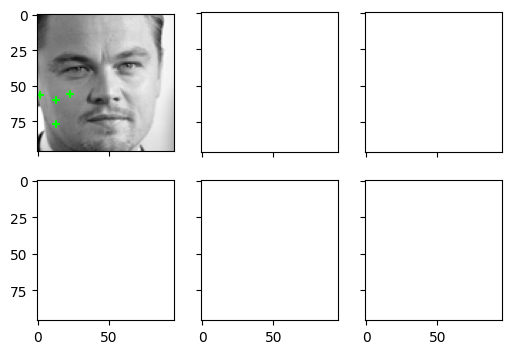

In [37]:
default_pics = [1884, 3602, 4217, 6224, 6268]
pic_size = 96
index = 0
rows = 2
cols = 3
fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
for row in range(rows):
    for col in range(cols):
        if row == 1 and col == 2:
            break
        ax[row,col].imshow(normalized_faces[default_pics[index]], cmap='gray')
        print(landmarks.iloc[index,0::2])
        ax[row,col].scatter(landmarks.iloc[default_pics[index], 0::2], landmarks.iloc[default_pics[index], 1::2], c="#0f0", marker='+')
        ax[row,col].scatter(landmarks_trained[y_pred[index], 0::2], y_pred[default_pics[index], 1::2], c="#f00", marker='+')
        ax[row,col].set_title('image index = %d' %(default_pics[index]),fontsize=10)
        index += 1